# Use a model trained on 2020 data to predict for 2019 train

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import torch
from matplotlib import pyplot as plt
from sklearn.metrics import accuracy_score, confusion_matrix
import albumentations as A
from albumentations.pytorch import ToTensorV2
from torch.utils.data import Subset, DataLoader
from argparse import Namespace
%matplotlib inline

In [2]:
torch.cuda.is_available()

True

In [4]:
from cassava.lmdb_dataset import *
from cassava.utils import *
from cassava.transforms import get_test_transforms
from cassava.models.model import LeafDoctorModel
from cassava.pipelines.train_model.nodes import score_model

In [7]:
parameters = context.catalog.load('parameters')

2020-12-23 21:46:36,569 - kedro.io.data_catalog - INFO - Loading data from `parameters` (MemoryDataSet)...


In [8]:
parameters

{'seed': 42,
 'cv_splits': 4,
 'cv_models_dir': 'data/06_models/cv_folds',
 'validation_size': 0.15,
 'data_loader_workers': 6,
 'classifier': {'gpus': -1,
  'batch_size': 24,
  'max_epochs': 100,
  'max_steps': 0,
  'auto_lr_find': 0,
  'lr': 0.001,
  'weight_decay': 0.0001,
  'early_stop_patience': 4,
  'reduce_lr_on_pleteau_patience': 2,
  'save_top_k_checkpoints': 1,
  'checkpoints_dir': 'data/06_models/classifier/checkpoints',
  'amp_level': 'O2',
  'precision': 16},
 'byol': {'gpus': -1,
  'batch_size': 6,
  'accumulate_grad_batches': 1,
  'max_epochs': 100,
  'max_steps': 0,
  'auto_lr_find': 0,
  'lr': 0.001,
  'reduce_lr_on_pleteau_patience': 1,
  'weight_decay': 0.0001,
  'limit_train_batches': 100,
  'limit_val_batches': 1,
  'early_stop_patience': 3,
  'amp_level': '02',
  'precision': 16,
  'on_test': {'lr': 0.0001,
   'auto_lr_find': 0,
   'max_epochs': 5,
   'early_stop_patience': 1}},
 'eval': {'batch_size': 16}}

In [9]:
train_lmdb = context.catalog.load('train_lmdb')

2020-12-23 21:46:36,605 - kedro.io.data_catalog - INFO - Loading data from `train_lmdb` (KedroImageLMDBDataSet)...


In [10]:
train_labels = context.catalog.load('train_labels')

2020-12-23 21:46:36,637 - kedro.io.data_catalog - INFO - Loading data from `train_labels` (CSVDataSet)...


In [11]:
duplicates = context.catalog.load('duplicates')

2020-12-23 21:46:36,673 - kedro.io.data_catalog - INFO - Loading data from `duplicates` (CSVDataSet)...


In [12]:
train_labels = train_labels.drop(duplicates[duplicates.ds2 == 'train_2020'].id2.values)

In [13]:
train_2020_indices = np.array(range(len(train_lmdb)))[train_lmdb.sources == 'train_2020']

In [14]:
train_2019_indices = np.array(range(len(train_lmdb)))[train_lmdb.sources == 'train_2019']

In [15]:
assert len(train_labels) == len(train_2020_indices), (len(train_labels), len(train_2020_indices))

In [33]:
train_2020 = DatasetFromSubset(Subset(train_lmdb, indices=train_2020_indices))

In [34]:
pd.Series(train_lmdb.labels[train_2019_indices]).value_counts(normalize=True)

3    0.466275
1    0.260685
2    0.127810
0    0.082034
4    0.063196
dtype: float64

In [35]:
unnorm = Unnormalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])

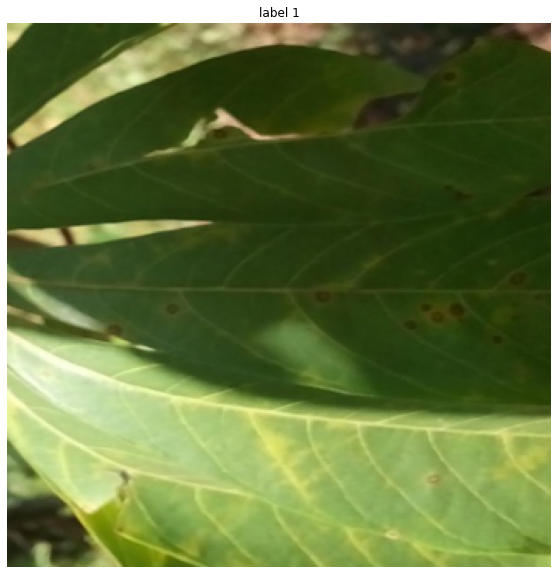

In [36]:
idx = np.random.choice(train_2019_indices)
img, label = train_lmdb[idx]
plt.figure(figsize=(10, 10))
plot_image(unnorm(get_test_transforms()(image=img)['image']), label=f'label {label}')
plt.show()

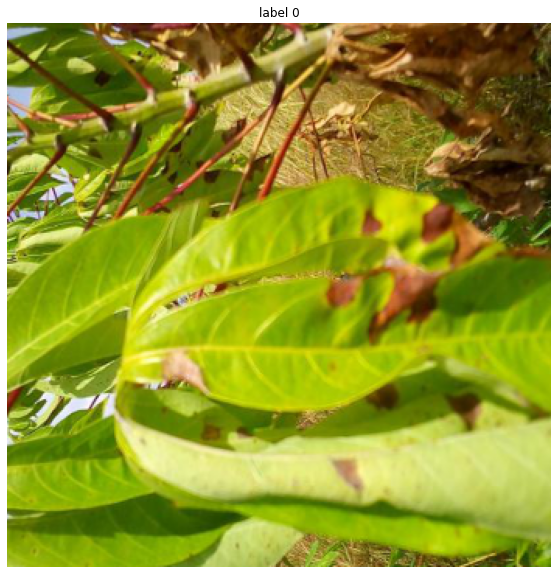

In [37]:
idx = np.random.choice(train_2020_indices)
img, label = train_lmdb[idx]
plt.figure(figsize=(10, 10))
plot_image(unnorm(get_test_transforms()(image=img)['image']), label=f'label {label}')

# Train model on 2020 data

In [38]:
from cassava.pipelines.train_model.nodes import split_data, train_model

In [39]:
train_indices, val_indices = split_data(train_2020, parameters)

In [40]:
assert not set(train_indices).intersection(train_2019_indices)

In [41]:
hparams = Namespace(**parameters['classifier'])
model = LeafDoctorModel(hparams)

In [45]:
model = LeafDoctorModel(hparams).load_from_checkpoint(checkpoint_path='../data/06_models/classifier/checkpoints/epoch=9_val_acc=0.8779.ckpt')

In [43]:
model = train_model(model, train_2020, train_indices, val_indices, parameters)

GPU available: True, used: True


2020-12-23 21:49:01,172 - lightning - INFO - GPU available: True, used: True


TPU available: False, using: 0 TPU cores


2020-12-23 21:49:01,177 - lightning - INFO - TPU available: False, using: 0 TPU cores


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


2020-12-23 21:49:01,181 - lightning - INFO - LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Using native 16bit precision.


2020-12-23 21:49:01,185 - lightning - INFO - Using native 16bit precision.



  | Name  | Type         | Params
---------------------------------------
0 | trunk | EfficientNet | 4.0 M 


2020-12-23 21:49:01,324 - lightning - INFO - 
  | Name  | Type         | Params
---------------------------------------
0 | trunk | EfficientNet | 4.0 M 


/home/boris/Documents/kaggle cassava/venv/lib/python3.8/site-packages/pytorch_lightning/utilities/distributed.py:45: UserWarning: Detected KeyboardInterrupt, attempting graceful shutdown...
  warnings.warn(*args, **kwargs)
Epoch 0: val_acc reached 0.00000 (best 0.00000), saving model to /home/boris/Documents/kaggle cassava/cassava/notebooks/data/06_models/classifier/checkpoints/epoch=0_val_acc=0.0000.ckpt as top 1


2020-12-23 21:53:06,318 - lightning - INFO - Epoch 0: val_acc reached 0.00000 (best 0.00000), saving model to /home/boris/Documents/kaggle cassava/cassava/notebooks/data/06_models/classifier/checkpoints/epoch=0_val_acc=0.0000.ckpt as top 1

2020-12-23 21:53:06,537 - root - INFO - Training finished


Traceback (most recent call last):
  File "/usr/lib/python3.8/multiprocessing/queues.py", line 245, in _feed
    send_bytes(obj)
  File "/usr/lib/python3.8/multiprocessing/connection.py", line 200, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/usr/lib/python3.8/multiprocessing/connection.py", line 411, in _send_bytes
    self._send(header + buf)
  File "/usr/lib/python3.8/multiprocessing/connection.py", line 368, in _send
    n = write(self._handle, buf)
BrokenPipeError: [Errno 32] Broken pipe


# Obtain model scores on 2019 train

In [46]:
score, preds = score_model(model, train_2020, val_indices, parameters)
print('Val score', score)

2020-12-23 21:53:51,947 - root - INFO - Scoring model



2020-12-23 21:56:45,964 - root - INFO - Validation scores:
{'accuracy': 0.8778816199376948, 'f1_score': 0.8799844608805824}
Val score {'accuracy': 0.8778816199376948, 'f1_score': 0.8799844608805824}


In [47]:
score, preds = score_model(model, train_lmdb, train_2019_indices, parameters)
print('2019 score', score)

2020-12-23 21:56:45,970 - root - INFO - Scoring model


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f9d0c577310>
Traceback (most recent call last):
  File "/home/boris/Documents/kaggle cassava/venv/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1203, in __del__
    self._shutdown_workers()
  File "/home/boris/Documents/kaggle cassava/venv/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1177, in _shutdown_workers
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "/usr/lib/python3.8/multiprocessing/process.py", line 149, in join
    res = self._popen.wait(timeout)
  File "/usr/lib/python3.8/multiprocessing/popen_fork.py", line 44, in wait
    if not wait([self.sentinel], timeout):
  File "/usr/lib/python3.8/multiprocessing/connection.py", line 931, in wait
    ready = selector.select(timeout)
  File "/usr/lib/python3.8/selectors.py", line 415, in select
    fd_event_list = self._selector.poll(timeout)
KeyboardInterrupt: 


2020-12-23 22:00:27,626 - root - INFO - Validation scores:
{'accuracy': 0.6254810613733036, 'f1_score': 0.593097798631877}


In [51]:
print('2019 score', score)

2019 score {'accuracy': 0.6254810613733036, 'f1_score': 0.593097798631877}


In [52]:
print('2019 score', score)

2019 score {'accuracy': 0.6254810613733036, 'f1_score': 0.593097798631877}


In [53]:
make_confusion_matrix(confusion_matrix(preds, train_lmdb.labels[train_2019_indices]))

NameError: name 'confusion_matrix' is not defined

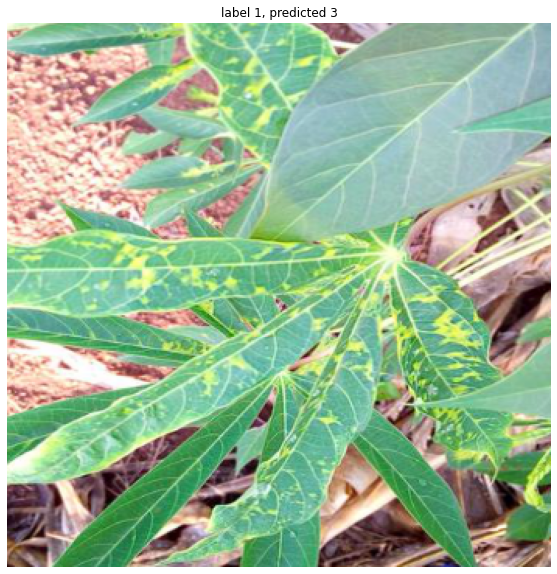

In [116]:
idx = np.random.choice(train_2019_indices)
img, label = train_lmdb[idx]
predicted = preds[np.argwhere(train_2019_indices == idx)[0][0]]
plt.figure(figsize=(10, 10))
plot_image(unnorm(get_test_transforms()(image=img)['image']), label=f'label {label}, predicted {predicted}')
plt.show()

In [119]:
mean_img_2019 = np.zeros_like(train_lmdb[train_2019_indices[0]][0])
for idx in tqdm(train_2019_indices):
    img, _ = train_lmdb[idx]
    mean_img_2019 += img

mean_img_2019 = mean_img_2019 / len(train_2019_indices)

In [165]:
mean_img_2019[0]

array([[0.03949767, 0.03058538, 0.04780231],
       [0.02754709, 0.04516913, 0.00283573],
       [0.02430626, 0.03443387, 0.01174803],
       ...,
       [0.03200324, 0.02471136, 0.03645939],
       [0.03889001, 0.05144825, 0.02572412],
       [0.02572412, 0.02167308, 0.03666194]])

In [157]:
mean_img_2019.shape

(512, 512, 3)

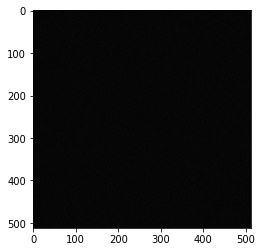

In [156]:
plt.imshow(mean_img_2019)

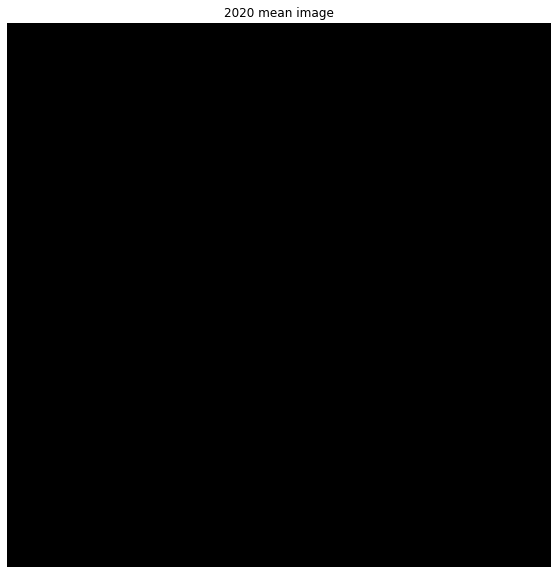

In [154]:
plt.figure(figsize=(10, 10))
plot_image(unnorm(get_test_transforms()(image=mean_img_2019)['image']), label=f'2020 mean image')
plt.show()

In [ ]:
mean_img_2020 = np.zeros_like(train_lmdb[train_2020_indices[0]][0])
for idx in tqdm(train_2020_indices):
    img, _ = train_lmdb[idx]
    mean_img_2019 += img

mean_img_2020 = mean_img_2020 / len(train_2020_indices)

In [ ]:
plt.figure(figsize=(10, 10))
plot_image(unnorm(get_test_transforms()(image=mean_img_2020)['image']), label=f'2020 mean image')
plt.show()

In [106]:
train_2020[0][0].shape

(512, 512, 3)

In [107]:
img.shape

(512, 512, 3)